In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from pathlib import Path
from pandasql import sqldf
from IPython.display import display, HTML
from tabulate import tabulate
from scipy.stats import pearsonr

plt.rcParams["figure.dpi"] = 100

In [33]:
cab = pd.read_csv("Cab_Data.csv")
cab["income"] = cab["Price Charged"] - cab["Cost of Trip"]

def replace_commas(x): return x.replace(",", "")

city = pd.read_csv("City.csv")
city.Population = city.Population.map(replace_commas)
city.Users = city.Users.map(replace_commas)
city = city.astype({"Population": np.int32, "Users": np.int32})
city = city.sort_values("City")
city["pop_to_users"] = (city.Users / city.Population) * 100

In [34]:
# Taken from https://www.kaggle.com/andradaolteanu/siim-covid-19-box-detect-dcm-metadata
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(round(_x, 5), round(_y, 5), format(round(value, 5), ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs): _show_on_single_plot(ax)
    else: _show_on_single_plot(axs)

# Transaction

In [35]:
transaction = pd.read_csv("Transaction_ID.csv")
transaction.columns = ['TransactionID', 'CustomerID', 'Payment_Mode']
transaction.head()

,TransactionID,CustomerID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [36]:
transaction.nunique()

TransactionID    440098
CustomerID        49171
Payment_Mode          2
dtype: int64

There's a mismatch between transaction ID numbers and `Cab_Data.csv`'s transaction ID numbers, one having less unique values than the others. We also notice that we have one missing city in `Cab_Data.csv`, hence the missing `Transaction ID` may be from this missing city. 

In [37]:
len(transaction)

440098

Asserted that `Transaction ID` is unique (each row different) (as `len(transaction)` equals its `.nunique()`). 

In [38]:
len(transaction) - len(cab), (len(transaction) - len(cab)) / len(transaction) * 100

(80706, 18.3381883126031)

Above shows how much `Transaction ID` missing, and its percentage to the total `Transaction ID` available (which is 18.34% missing). 

What we can tell is, since `SAN FRANCISCO CA` is missing from `Cab_Data.csv`, these data might be for `SAN FRANCISCO CA`. Let's see the percentage of `Users` from `SAN FRANCISCO CA` compared to total number of `Users`. 

In [39]:
(city.Users[city.City == "SAN FRANCISCO CA"].values /
            city.Users.sum() * 100)[0]

16.553537510858927

About 16.6%. Not the exact number we'd expected from the number of missing `Transaction ID`. Seems like there are more missing data. 

Next, we know that we have 49171 distinct users recorded in `Transaction_ID.csv`, so let's check it against the total number of users we have from `City.csv`. 

In [40]:
city.Users.sum()

1290413

This means that the data was taken only from a subset of the whole lot of users. Let's see if all the data from `Cab_Data.csv` is inside `Transaction_ID.csv`. That is, any non matches? 

In [42]:
len(set(transaction["TransactionID"]).difference(set(cab["Transaction ID"])))

80706

It matches the number of unique data. However just to make sure, switch the sets in the opposite direction to make sure it returns an empty set. 

In [43]:
set(cab["Transaction ID"]).difference(set(transaction["TransactionID"]))

set()

Alright. Now let's see how many users paid by Card than Cash. 

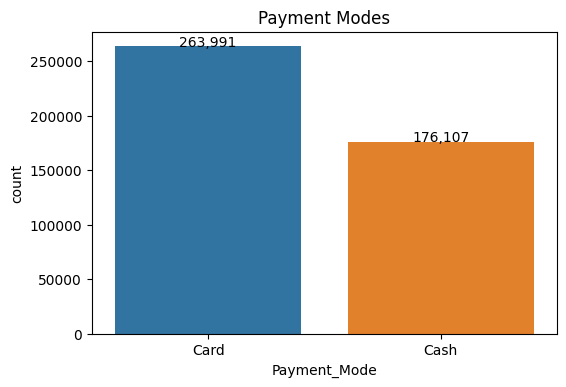

In [44]:
ax = sns.countplot(x=transaction.Payment_Mode)
ax.set_title("Payment Modes")
show_values_on_bars(ax)

To see how much payment type for each company, we shall join the tables using left join. 

In [47]:
cab_tran = cab.join(transaction)
cab_tran = cab_tran.drop(columns=["TransactionID"])
cab_tran

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,income,CustomerID,Payment_Mode
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,57.3150,29290,Card
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,23.6660,27703,Card
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,27.5680,28712,Cash
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,25.7980,28020,Cash
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,16.8440,27182,Card
...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,5.8800,52022,Cash
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,6.9020,52234,Cash
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,87.4200,52326,Card
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,32.1420,51413,Card


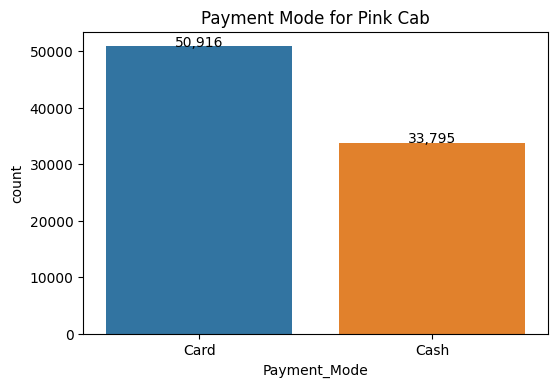

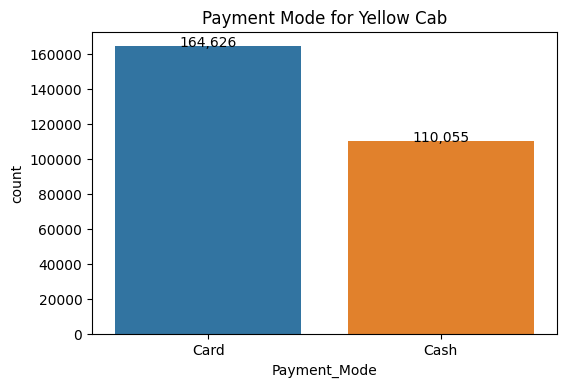

In [48]:
for company_name, data in cab_tran.groupby("Company")["Payment_Mode"]:
    ax = sns.countplot(x=data)
    plt.title(f"Payment Mode for {company_name}")
    show_values_on_bars(ax)
    plt.show()

Not much differences in terms of ratio. Card or Cash payment type can be said independent of Yellow Cab. (To say more about independence, some statistical test requires to be done, but we won't deal with that. All we want to know is whether one is more worth investing or not, so if there's a difference in ratio then only we know which type of user prefers a different payment type for which company. This isn't seen in the above graph so we can safely continue with EDA of other information). 

# Customer ID

In [49]:
customer = pd.read_csv("Customer_ID.csv")
customer.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [50]:
customer.columns = ['CustomerID', 'Gender', 'Age', 'Income (USD/Month)']

In [51]:
customer.nunique()

CustomerID            49171
Gender                    2
Age                      48
Income (USD/Month)    23341
dtype: int64

The number of unique `Customer ID` matches those from `Transaction ID`. We shall check whether they're equal or not, with sets. 

In [52]:
print(set(transaction["CustomerID"]).difference(set(customer["CustomerID"])))
print(set(customer["CustomerID"]).difference(set(transaction["CustomerID"])))

set()
set()


Ok they match, so we can perform *inner join* between the two data. This way we can connect with `Cab_Data.csv` since `Cab_Data.csv` doesn't have a `Customer ID` previously. Otherwise, we could join to `cab_tran`. We shall do the latter to prevent unnecessary extra join. 

The reason we do inner join is because of our many-to-one relationship, and to broadcast `customer ID`, we need an *inner join*. Doing *left join* here would result it only joining one-to-one (so only the first one that exist, leaving the rest as NaN values). 

Also we are using another type of library to use SQL directly. One tries to use the following code
```
cab_tran_cus = cab_tran.join(customer, rsuffix="_r", how="left")
```
and fails to meet what one wants to do. But SQL success with the same code method. Hence we would use SQL. We get how to use it from [this blog post](https://towardsdatascience.com/how-to-use-sql-in-pandas-62d8a0f6341).

In [53]:
pysqldf = lambda q: sqldf(q, globals())

In [54]:
q = """
    SELECT * 
    FROM cab_tran a
    INNER JOIN customer b
    ON a.CustomerID = b.CustomerID;
"""

cab_tran_cus = pysqldf(q)
# Remove duplicate columns
cab_tran_cus = cab_tran_cus.loc[:, ~cab_tran_cus.columns.duplicated()]
cab_tran_cus

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,income,CustomerID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,57.3150,29290,Card,Male,28,10813
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,23.6660,27703,Card,Male,27,9237
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,27.5680,28712,Cash,Male,53,11242
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,25.7980,28020,Cash,Male,23,23327
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,16.8440,27182,Card,Male,33,8536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,5.8800,52022,Cash,Female,42,10816
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,6.9020,52234,Cash,Female,50,13093
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,87.4200,52326,Card,Female,18,22843
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,32.1420,51413,Card,Male,27,20802


In [55]:
cab_tran_cus.isnull().any()

Transaction ID        False
Date of Travel        False
Company               False
City                  False
KM Travelled          False
Price Charged         False
Cost of Trip          False
income                False
CustomerID            False
Payment_Mode          False
Gender                False
Age                   False
Income (USD/Month)    False
dtype: bool

Successful join. Let's see the demographics of information we got from `Customer_ID.csv`. Start with `Gender`. 

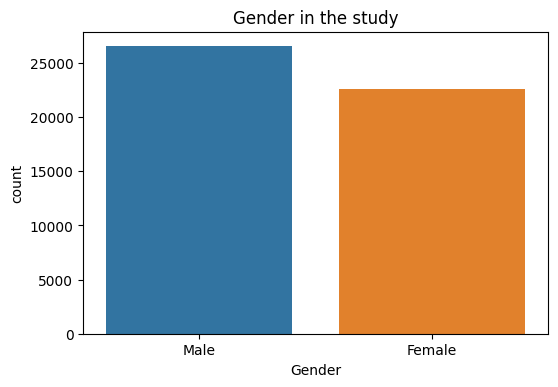

In [56]:
sns.countplot(x=customer.Gender)
_ = plt.title("Gender in the study")

Let's ensure there's no biases in which Gender riding which type of company vehicle. Perhaps one gender prefer one type of company than another? 

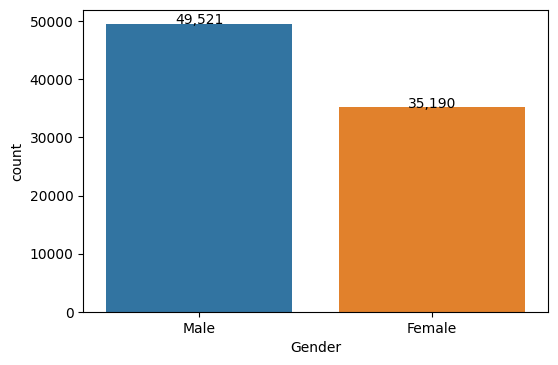

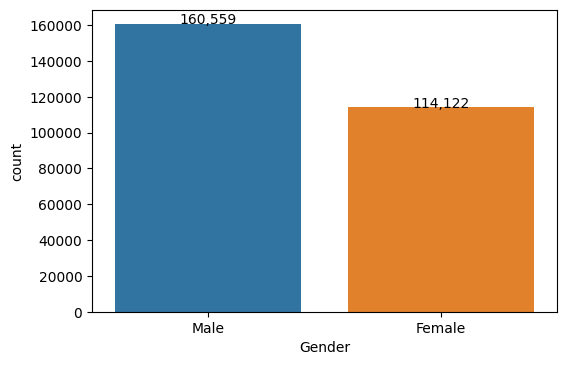

In [60]:
for title, data in cab_tran_cus.groupby("Company")["Gender"]:
    ax = sns.countplot(x=data)
    show_values_on_bars(ax)
    plt.show()

No biases. Next, check next on `Age`. 

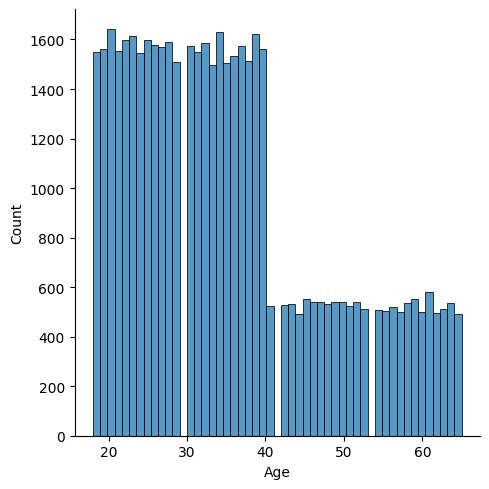

In [63]:
sns.displot(x=customer.Age)

Looks like there're some age range that are totally missing. These are the gaps between the bins. Let's check out whether one `Age` prefers one type of company than another. 

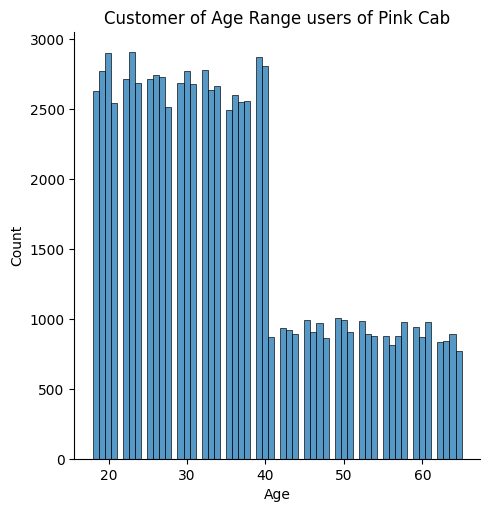

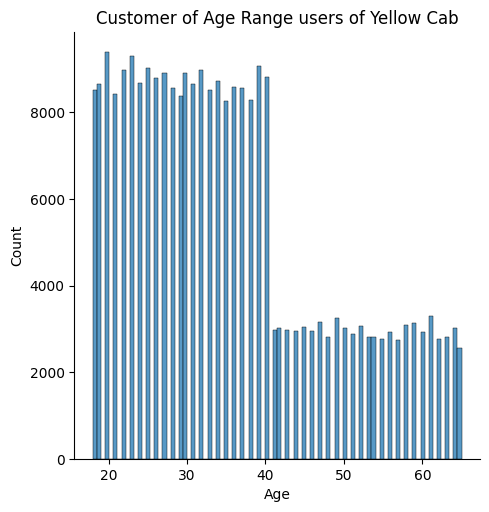

In [65]:
for title, data in cab_tran_cus.groupby("Company").Age:
    sns.displot(x=data)
    plt.title(f"Customer of Age Range users of {title}")
    plt.show()

This is unsure of how to analyze. However, one suggests it may be data collection process being different, resulting in some age range that is missing from both company are also different. In particular, Age range for `Yellow Cab` have more holes between available age range than `Pink Cab`. This, however, does not prevent us from investing in `Yellow Cab`. 

Finally, check on Income. 

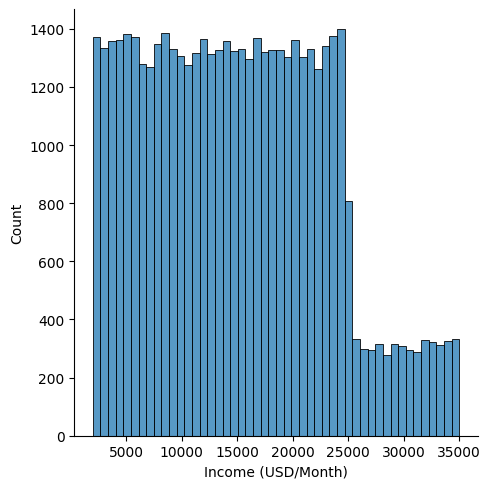

In [66]:
sns.displot(x=customer["Income (USD/Month)"])

Does one with certain threshold of income prefers one type of company over another? It is known beforehand that `Yellow Cab` charge more expensive than `Pink Cab`. Is it due to the competitiveness that `Pink Cab` charge less, or `Yellow Cab` targets the luxury? 

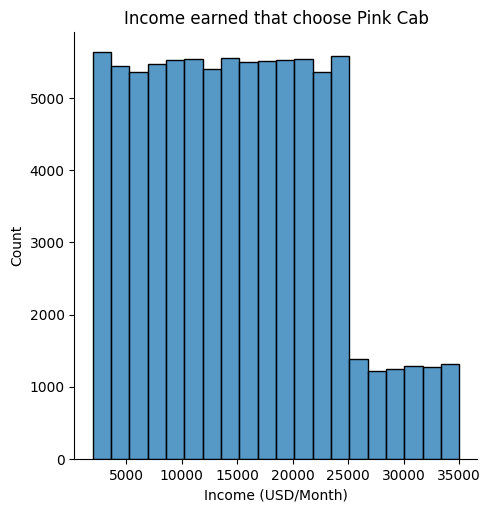

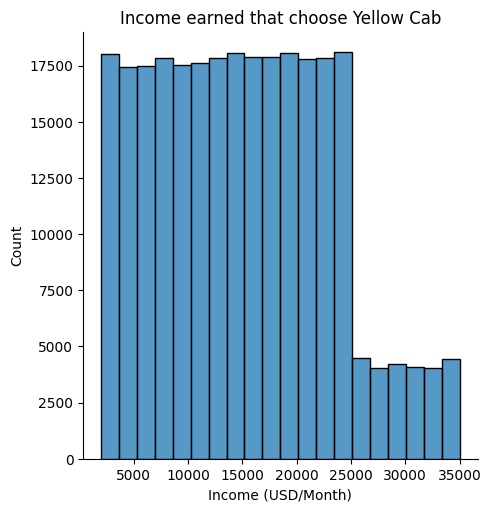

In [68]:
for company, data in cab_tran_cus.groupby("Company")["Income (USD/Month)"]:
    sns.displot(x=data, bins=20)
    plt.title(f"Income earned that choose {company}")
    plt.show()

There are no clear relationship showing it does so. This is the end of the analysis. Although we can get more information from the data, it may or may not be important towards choosing which company where we can invest. 

In conclusion, `Yellow Cab` is a better investment company than `Pink Cab`, based on the analysis. 